# VI vs Analytical Posterior for Bayesian Linear Regression

This notebook demonstrates that our VI framework recovers the correct
Bayesian posterior on a problem where the answer is known analytically.

**Setup**: $y = Xw + \epsilon$, with prior $w \sim \mathcal{N}(0, \alpha^{-1} I)$
and likelihood $y|X,w \sim \mathcal{N}(Xw, \beta^{-1} I)$.

The analytical posterior is:
$$\Sigma_{\text{post}} = (\alpha I + \beta X^T X)^{-1}, \quad \mu_{\text{post}} = \beta \Sigma_{\text{post}} X^T y$$

We also show:
- How to use `make_parameter` for arbitrary tensors
- How to define multi-layer models via lists
- Proof that `sample_all_parameters` never mutates the original model

In [1]:
import jax
import jax.numpy as jnp
from jax import random
import optax
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

from BayesianJaxModels import (
    AbstractParameter,
    BayesianLinear,
    GaussianParameter,
    Module,
    gaussian_entropy,
    freeze_stdvs,
    freeze_means,
    unfreeze_all,
    make_parameter,
    sample_all_parameters,
    get_parameter_count,
)

## 1. Generate Data

In [2]:
n_samples = 150
n_features = 3
alpha = 1.0    # prior precision
beta = 4.0     # likelihood precision (noise_std = 0.5)
noise_std = 1.0 / jnp.sqrt(beta)

key = random.key(42)
k1, k2, k3 = random.split(key, 3)
w_true = random.normal(k1, (n_features,))
X = random.normal(k2, (n_samples, n_features))
y = X @ w_true + noise_std * random.normal(k3, (n_samples,))

print(f"True weights: {w_true}")
print(f"Data: X {X.shape}, y {y.shape}, noise_std={noise_std:.3f}")

True weights: [ 0.07592554 -0.48634264  1.2903206 ]
Data: X (150, 3), y (150,), noise_std=0.500


## 2. Analytical Posterior

In [3]:
Sigma_post_inv = alpha * jnp.eye(n_features) + beta * X.T @ X
Sigma_post = jnp.linalg.inv(Sigma_post_inv)
mu_post = beta * Sigma_post @ X.T @ y
stdv_post = jnp.sqrt(jnp.diag(Sigma_post))

print("Analytical posterior:")
for i in range(n_features):
    print(f"  w[{i}]: {mu_post[i]:.4f} +/- {stdv_post[i]:.4f}")

Analytical posterior:
  w[0]: 0.1182 +/- 0.0436
  w[1]: -0.5546 +/- 0.0425
  w[2]: 1.2842 +/- 0.0397


## 3. Variational Inference with BayesianJaxModels

In [4]:
def elbo_loss(dynamic, static, X, y, beta, alpha, key):
    """Negative ELBO for Bayesian linear regression."""
    model = unfreeze_all(dynamic, static)
    y_pred = model(X, key=key, sample=True).squeeze(-1)
    log_lik = -0.5 * beta * jnp.sum((y - y_pred) ** 2)
    W_sample = model.W.sample(key)
    log_prior = -0.5 * alpha * jnp.sum(W_sample ** 2)
    entropy = gaussian_entropy(model)
    return -(log_lik + log_prior + entropy)


# Build model: single Bayesian linear, no bias
model = BayesianLinear(
    n_features, 1, use_bias=False, bayesian=True,
    param_type=GaussianParameter, init_raw_stdv=0.1, key=random.key(0)
)

In [5]:
# ---- Stage 1: MAP (freeze stdvs, optimise means) ----
dynamic, static = freeze_stdvs(model)
optimizer = optax.adam(1e-2)
opt_state = optimizer.init(dynamic)

@jax.jit
def map_step(dynamic, opt_state, key):
    loss, grads = jax.value_and_grad(elbo_loss)(dynamic, static, X, y, beta, alpha, key)
    updates, opt_state = optimizer.update(grads, opt_state, dynamic)
    dynamic = optax.apply_updates(dynamic, updates)
    return dynamic, opt_state, loss

key = random.key(1)
map_losses = []
for i in range(5000):
    key, subkey = random.split(key)
    dynamic, opt_state, loss = map_step(dynamic, opt_state, subkey)
    map_losses.append(float(loss))

model = unfreeze_all(dynamic, static)
print("After MAP:")
print(f"  VI mean:     {model.W.mean.ravel()}")
print(f"  Analytical:  {mu_post}")

After MAP:
  VI mean:     [ 0.10996321 -0.54911554  1.2852697 ]
  Analytical:  [ 0.11819106 -0.5545711   1.2842412 ]


In [6]:
# ---- Stage 2: VI (freeze means, optimise stdvs) ----
dynamic, static = freeze_means(model)
optimizer2 = optax.adam(1e-3)
opt_state2 = optimizer2.init(dynamic)

@jax.jit
def vi_step(dynamic, opt_state, key):
    keys = random.split(key, 8)
    def mc_elbo(d):
        return jnp.mean(jax.vmap(
            lambda k: elbo_loss(d, static, X, y, beta, alpha, k)
        )(keys))
    loss, grads = jax.value_and_grad(mc_elbo)(dynamic)
    updates, opt_state = optimizer2.update(grads, opt_state, dynamic)
    dynamic = optax.apply_updates(dynamic, updates)
    return dynamic, opt_state, loss

key = random.key(2)
vi_losses = []
for i in range(5000):
    key, subkey = random.split(key)
    dynamic, opt_state2, loss = vi_step(dynamic, opt_state2, subkey)
    vi_losses.append(float(loss))

model = unfreeze_all(dynamic, static)
vi_mean = model.W.mean.ravel()
vi_stdv = model.W.stdv.ravel()

print("After VI:")
for i in range(n_features):
    print(f"  w[{i}]: {vi_mean[i]:.4f} +/- {vi_stdv[i]:.4f}")

After VI:
  w[0]: 0.1100 +/- 0.0439
  w[1]: -0.5491 +/- 0.0418
  w[2]: 1.2853 +/- 0.0400


## 4. Compare: VI vs Analytical Posterior

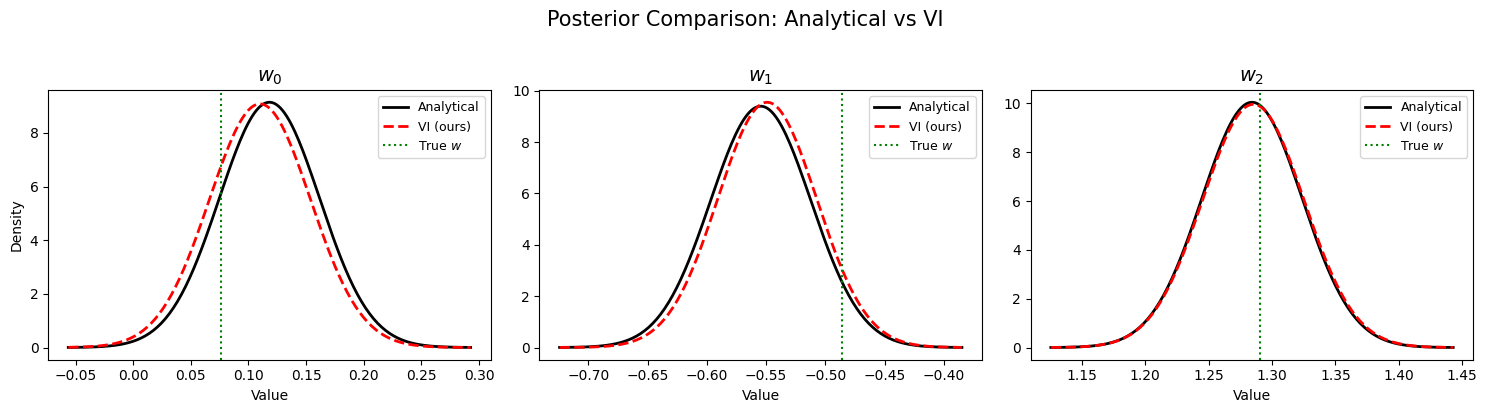

In [7]:
fig, axes = plt.subplots(1, n_features, figsize=(5 * n_features, 4))

for i, ax in enumerate(axes):
    lo = float(mu_post[i] - 4 * stdv_post[i])
    hi = float(mu_post[i] + 4 * stdv_post[i])
    x_grid = np.linspace(lo, hi, 200)

    # Analytical
    ax.plot(x_grid, norm.pdf(x_grid, float(mu_post[i]), float(stdv_post[i])),
            'k-', lw=2, label='Analytical')

    # VI
    ax.plot(x_grid, norm.pdf(x_grid, float(vi_mean[i]), float(vi_stdv[i])),
            'r--', lw=2, label='VI (ours)')

    # True weight
    ax.axvline(float(w_true[i]), color='green', ls=':', lw=1.5, label='True $w$')

    ax.set_title(f'$w_{i}$', fontsize=14)
    ax.set_xlabel('Value')
    if i == 0:
        ax.set_ylabel('Density')
    ax.legend(fontsize=9)

fig.suptitle('Posterior Comparison: Analytical vs VI', fontsize=15, y=1.02)
fig.tight_layout()
plt.show()

In [8]:
# Numerical comparison
print(f"{'':>8} {'Analytical':>22} {'VI (ours)':>22}")
print(f"{'':>8} {'mean':>10} {'std':>10}  {'mean':>10} {'std':>10}")
print('-' * 56)
for i in range(n_features):
    print(f"  w[{i}]  {mu_post[i]:>10.4f} {stdv_post[i]:>10.4f}  "
          f"{vi_mean[i]:>10.4f} {vi_stdv[i]:>10.4f}")

                     Analytical              VI (ours)
               mean        std        mean        std
--------------------------------------------------------
  w[0]      0.1182     0.0436      0.1100     0.0439
  w[1]     -0.5546     0.0425     -0.5491     0.0418
  w[2]      1.2842     0.0397      1.2853     0.0400


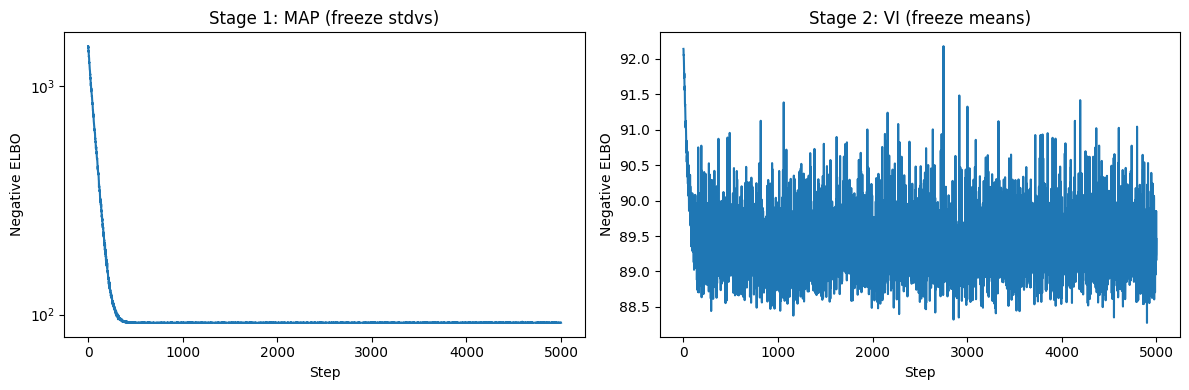

In [9]:
# Training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(map_losses)
ax1.set_title('Stage 1: MAP (freeze stdvs)')
ax1.set_xlabel('Step'); ax1.set_ylabel('Negative ELBO'); ax1.set_yscale('symlog')
ax2.plot(vi_losses)
ax2.set_title('Stage 2: VI (freeze means)')
ax2.set_xlabel('Step'); ax2.set_ylabel('Negative ELBO')
fig.tight_layout()
plt.show()

---
## 5. `make_parameter` — wrapping arbitrary tensors

`make_parameter` lets you create Bayesian parameters of **any shape** —
scalars, vectors, matrices, higher-order tensors — without going through a layer.

In [10]:
class CustomODE(Module):
    """Example: Bayesian Lotka-Volterra with arbitrary parameter shapes."""
    growth: AbstractParameter           # scalar
    interaction: AbstractParameter       # matrix
    bias: AbstractParameter              # vector (deterministic)

    def __init__(self, n_species, *, key):
        self.growth = make_parameter(jnp.ones(n_species))                       # Bayesian vector
        self.interaction = make_parameter(jnp.zeros((n_species, n_species)))     # Bayesian matrix
        self.bias = make_parameter(jnp.zeros(n_species), bayesian=False)         # deterministic

    def __call__(self, x, *, key=None, sample=False):
        if sample:
            k1, k2 = random.split(key)
            r = self.growth.sample(k1)
            A = self.interaction.sample(k2)
        else:
            r = self.growth.mean
            A = self.interaction.mean
        return x * (r + A @ x) + self.bias.mean


ode = CustomODE(4, key=random.key(0))
params = ode.get_parameters()
print("Named parameters:")
for name, p in params.items():
    print(f"  {name}: {type(p).__name__}, shape={p.shape}")

print(f"\nParameter counts: {get_parameter_count(ode)}")

# Forward pass works
x = jnp.ones(4)
print(f"\nDeterministic: {ode(x, sample=False)}")
print(f"Sampled:       {ode(x, key=random.key(1), sample=True)}")

Named parameters:
  growth: GaussianParameter, shape=(4,)
  interaction: GaussianParameter, shape=(4, 4)
  bias: DeterministicParameter, shape=(4,)

Parameter counts: {'total': 24, 'bayesian': 20, 'deterministic': 4}

Deterministic: [1. 1. 1. 1.]
Sampled:       [0.9997432 0.9995773 1.0009354 1.0004421]


---
## 6. Multi-layer models via lists

Store layers in a `list` field. `get_parameters()` automatically discovers them
with indexed names like `layers[0].W`, `layers[1].b`, etc.

In [11]:
class BayesianMLP(Module):
    layers: list

    def __init__(self, dims: list[int], *, key):
        keys = random.split(key, len(dims) - 1)
        self.layers = [
            BayesianLinear(dims[i], dims[i + 1], key=keys[i])
            for i in range(len(dims) - 1)
        ]

    def __call__(self, x, *, key, sample=True):
        keys = random.split(key, len(self.layers)) if sample else [None] * len(self.layers)
        for i, layer in enumerate(self.layers):
            x = layer(x, key=keys[i], sample=sample)
            if i < len(self.layers) - 1:
                x = jax.nn.tanh(x)
        return x


mlp = BayesianMLP([5, 32, 16, 1], key=random.key(0))

# Introspection
params = mlp.get_parameters()
print("All named parameters:")
for name, p in params.items():
    print(f"  {name}: {type(p).__name__}, shape={p.shape}")

print(f"\nCounts: {get_parameter_count(mlp)}")

# Forward
x = jnp.ones((8, 5))
y = mlp(x, key=random.key(1), sample=True)
print(f"\nOutput shape: {y.shape}")

# Freeze stdvs, take gradient
dynamic, static = freeze_stdvs(mlp)

@jax.grad
def grad_fn(dynamic):
    model = unfreeze_all(dynamic, static)
    return jnp.sum(model(x, key=random.key(42), sample=True))

grads = grad_fn(dynamic)
n_grad_leaves = sum(1 for g in jax.tree.leaves(grads) if g is not None)
print(f"Gradient leaves (means only): {n_grad_leaves}")

All named parameters:
  layers[0].W: GaussianParameter, shape=(32, 5)
  layers[0].b: GaussianParameter, shape=(32,)
  layers[1].W: GaussianParameter, shape=(16, 32)
  layers[1].b: GaussianParameter, shape=(16,)
  layers[2].W: GaussianParameter, shape=(1, 16)
  layers[2].b: GaussianParameter, shape=(1,)

Counts: {'total': 737, 'bayesian': 737, 'deterministic': 0}

Output shape: (8, 1)
Gradient leaves (means only): 6


---
## 7. `sample_all_parameters` does not modify the original model

Why it's safe:
- Equinox modules are **frozen dataclasses** (immutable after `__init__`)
- JAX arrays are **immutable** (backed by XLA device buffers)
- `eqx.tree_at` returns a **new** pytree — never mutates

In [12]:
original = BayesianLinear(4, 3, key=random.key(0))
original_W = original.W.mean.copy()
original_b = original.b.mean.copy()

# Sample 100 different models from it
for i in range(100):
    sampled = sample_all_parameters(original, random.key(i))

# Original is untouched
assert jnp.array_equal(original.W.mean, original_W)
assert jnp.array_equal(original.b.mean, original_b)
assert original is not sampled      # different object
assert original.W is not sampled.W  # different W

print("Original mean (unchanged):   ", original.W.mean[0, :3])
print("Last sampled mean (different):", sampled.W.mean[0, :3])
print("\nAll checks passed.")

Original mean (unchanged):    [ 0.6338426  -0.58812046 -0.505168  ]
Last sampled mean (different): [ 0.6337157  -0.58832014 -0.5051851 ]

All checks passed.
